# Fast Training example using only histone modifications.

In [ ]:
import os
os.system('pip install -q glob2==0.7 requests pytest-shutil==1.7.0  pyBigWig urllib3==1.26.14 tqdm==4.64.1 joblib==1.2.0 ipywidgets==8.0.4 biopython')
os.system('pip install pydca --no-deps')

0

In [ ]:
!pip install pyBigWig

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!rm -r GM12878_hg19_zscore_all
!unzip /content/drive/MyDrive/Projects/PyMEGABASE/GM12878_hg19_zscore_all.zip

Streaming output truncated to the last 5000 lines.
  inflating: GM12878_hg19_zscore_all/H3K27me3-human_5/chr16.track  
  inflating: GM12878_hg19_zscore_all/H3K27me3-human_5/chr20.track  
  inflating: GM12878_hg19_zscore_all/H3K27me3-human_5/chr4.track  
  inflating: GM12878_hg19_zscore_all/H3K27me3-human_5/chr6.track  
  inflating: GM12878_hg19_zscore_all/H3K27me3-human_5/chr17.track  
  inflating: GM12878_hg19_zscore_all/H3K27me3-human_5/chr19.track  
  inflating: GM12878_hg19_zscore_all/H3K27me3-human_5/chrX.track  
   creating: GM12878_hg19_zscore_all/WRNIP1-human_3/
 extracting: GM12878_hg19_zscore_all/WRNIP1-human_3/exp_name.txt  
  inflating: GM12878_hg19_zscore_all/WRNIP1-human_3/chr10.track  
  inflating: GM12878_hg19_zscore_all/WRNIP1-human_3/chr22.track  
 extracting: GM12878_hg19_zscore_all/WRNIP1-human_3/exp_accession.txt  
  inflating: GM12878_hg19_zscore_all/WRNIP1-human_3/chr2.track  
  inflating: GM12878_hg19_zscore_all/WRNIP1-human_3/chr13.track  
  inflating: GM12878_

In [ ]:
!rm -r AMD_ML_Chromatin/
!git clone https://github.com/ed29rice/AMD_ML_Chromatin.git

rm: cannot remove 'AMD_ML_Chromatin/': No such file or directory
Cloning into 'AMD_ML_Chromatin'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (198/198), done.
remote: Total 253 (delta 79), reused 221 (delta 50), pack-reused 0 (from 0)
Receiving objects: 100% (253/253), 3.23 MiB | 22.50 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [1]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import math
from tempfile import TemporaryDirectory
import copy
import time
import seaborn as sns
from typing import Tuple
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
import pickle

In [2]:
%load_ext autoreload
%autoreload 2
import AMD_ML_Chromatin.TECSAS as TECSAS

In [3]:
NEXP = 15
exps = np.loadtxt('./GM12878_hg19_zscore_all/_unique_exp.txt',dtype=str)
random_sel = np.random.choice(exps, NEXP, replace=False)
with open('./GM12878_hg19_zscore_all/unique_exp.txt','w') as f:
    for l in random_sel:
        f.write(l+'\n')

In [4]:
!mv ./GM12878_hg19_zscore_all/unique_exp.txt ./GM12878_hg19_zscore_all/_unique_exp.txt
!echo H2AFZ >> ./GM12878_hg19_zscore_all/unique_exp.txt
!echo H3K27ac >> ./GM12878_hg19_zscore_all/unique_exp.txt
!echo H3K27me3 >> ./GM12878_hg19_zscore_all/unique_exp.txt
!echo H3K36me3 >> ./GM12878_hg19_zscore_all/unique_exp.txt
!echo H3K4me1 >> ./GM12878_hg19_zscore_all/unique_exp.txt
!echo H3K4me2 >> ./GM12878_hg19_zscore_all/unique_exp.txt
!echo H3K4me3 >> ./GM12878_hg19_zscore_all/unique_exp.txt
!echo H3K79me2 >> ./GM12878_hg19_zscore_all/unique_exp.txt
!echo H3K9ac >> ./GM12878_hg19_zscore_all/unique_exp.txt
!echo H3K9me3 >> ./GM12878_hg19_zscore_all/unique_exp.txt
!echo H4K20me1 >> ./GM12878_hg19_zscore_all/unique_exp.txt
!echo minus-small-RNA-seq >> ./GM12878_hg19_zscore_all/unique_exp.txt
!echo minus-total-RNA-seq >> ./GM12878_hg19_zscore_all/unique_exp.txt
!echo plus-small-RNA-seq >> ./GM12878_hg19_zscore_all/unique_exp.txt
!echo plus-total-RNA-seq >> ./GM12878_hg19_zscore_all/unique_exp.txt

In [ ]:
#Initialize PyMEGABASE
cell='GM12878'
pymb=TECSAS.data_process(cell_line=cell, assembly='hg19', organism='human',
        signal_type='signal p-value',ref_cell_line_path='./GM12878_hg19_zscore_all', cell_line_path='./GM12878_hg19_zscore_all',
        histones=True,tf=False,small_rna=False,total_rna=False,n_states=10,res=50)

n_neigbors = 2
n_predict = 1

print(n_neigbors,n_predict)


testmatrix=pymb.get_tmatrix(range(1,23,2))
vmatrix=pymb.get_tmatrix(range(1,23,4))
tmatrix=pymb.get_tmatrix(range(2,23,2))

train_set=tmatrix.T
validation_set=vmatrix.T
test_set=testmatrix.T

training_averages=tmatrix.T
validation_set=vmatrix.T
test_set=testmatrix.T

train_data=torch.tensor(training_averages.astype(int))
val_data=torch.tensor(validation_set.astype(int))
test_data=torch.tensor(test_set.astype(int))
n_exp=int(training_averages[:,1:].shape[1]/5)
print(train_data.size(),val_data.size(),test_data.size())

print(train_set.shape,validation_set.shape,train_set.shape)


2 1
To train the following experiments are used:
plus-small-RNA-seq
plus-total-RNA-seq
H3K4me2
H3K27me3
H3K4me1
H3K9me3
minus-small-RNA-seq
H2AFZ
H3K9ac
H3K4me3
H4K20me1
H3K27ac
minus-total-RNA-seq
H3K36me3
H3K79me2
To train the following experiments are used:
plus-small-RNA-seq
plus-total-RNA-seq
H3K4me2
H3K27me3
H3K4me1
H3K9me3
minus-small-RNA-seq
H2AFZ
H3K9ac
H3K4me3
H4K20me1
H3K27ac
minus-total-RNA-seq
H3K36me3
H3K79me2
To train the following experiments are used:
plus-small-RNA-seq
plus-total-RNA-seq
H3K4me2
H3K27me3
H3K4me1
H3K9me3
minus-small-RNA-seq
H2AFZ
H3K9ac
H3K4me3
H4K20me1
H3K27ac
minus-total-RNA-seq
H3K36me3
H3K79me2
torch.Size([26310, 76]) torch.Size([14188, 76]) torch.Size([26142, 76])
(26310, 76) (14188, 76) (26310, 76)


In [ ]:
  # Use even chromosomes (2, 4, 6, ..., 22) for training
  train_chroms = list(range(2, 23, 2))
  # Use odd chromosomes (1, 3, 5, ..., 21) for testing
  test_chroms = list(range(1, 23, 2))

  # Get training data from even chromosomes
  train_set, val_set, _, train_averages, loci_indx = pymb.training_data_chrom(
      train_chroms=train_chroms,
      n_neigbors=n_neigbors,
      train_per=0.8,
      n_predict=n_predict
  )

  # Get test data from odd chromosomes
  test_set, _, _, test_averages, test_loci_indx = pymb.training_data_chrom(
      train_chroms=test_chroms,
      n_neigbors=n_neigbors,
      train_per=0.0,  # Set to 0 to get all data as test
      n_predict=n_predict
  )
  # Combine averages from both sets
  all_averages = train_averages

  # Save the data
  data = [train_set, val_set, test_set, all_averages, loci_indx]
  with open('cont_chrom_even_train_odd_test_HR_GM12878_hg19.pickle', 'wb') as handle:
      pickle.dump(data, handle)

  # Create the loci indices
  all_loci = np.array(list(range(len(all_averages[0]))))
  ntrain_loci = all_loci[loci_indx]
  nval_loci = all_loci[~loci_indx][::2]
  ntest_loci = np.array(list(range(len(test_averages[0]))))  # All odd chromosome loci

  # Convert to tensors
  train_data = torch.tensor(train_set, dtype=torch.float)
  val_data = torch.tensor(val_set, dtype=torch.float)
  test_data = torch.tensor(test_set, dtype=torch.float)
  print(train_data.size(), val_data.size(), test_data.size())

To train the following experiments are used:
plus-small-RNA-seq
plus-total-RNA-seq
H3K4me2
H3K27me3
H3K4me1
H3K9me3
minus-small-RNA-seq
H2AFZ
H3K9ac
H3K4me3
H4K20me1
H3K27ac
minus-total-RNA-seq
H3K36me3
H3K79me2
To train the following experiments are used:
plus-small-RNA-seq
plus-total-RNA-seq
H3K4me2
H3K27me3
H3K4me1
H3K9me3
minus-small-RNA-seq
H2AFZ
H3K9ac
H3K4me3
H4K20me1
H3K27ac
minus-total-RNA-seq
H3K36me3
H3K79me2
To train the following experiments are used:
plus-small-RNA-seq
plus-total-RNA-seq
H3K4me2
H3K27me3
H3K4me1
H3K9me3
minus-small-RNA-seq
H2AFZ
H3K9ac
H3K4me3
H4K20me1
H3K27ac
minus-total-RNA-seq
H3K36me3
H3K79me2
To train the following experiments are used:
plus-small-RNA-seq
plus-total-RNA-seq
H3K4me2
H3K27me3
H3K4me1
H3K9me3
minus-small-RNA-seq
H2AFZ
H3K9ac
H3K4me3
H4K20me1
H3K27ac
minus-total-RNA-seq
H3K36me3
H3K79me2
torch.Size([26306, 76]) torch.Size([13069, 76]) torch.Size([26138, 76])


In [113]:
  # Get test data from odd chromosomes
  test_set2, _, _, test_averages2, test_loci_indx = pymb.training_data_chrom(
      train_chroms=[2],
      n_neigbors=n_neigbors,
      train_per=0.0,  # Set to 0 to get all data as test
      n_predict=n_predict
  )

To train the following experiments are used:
plus-small-RNA-seq
plus-total-RNA-seq
H3K4me2
H3K27me3
H3K4me1
H3K9me3
minus-small-RNA-seq
H2AFZ
H3K9ac
H3K4me3
H4K20me1
H3K27ac
minus-total-RNA-seq
H3K36me3
H3K79me2
To train the following experiments are used:
plus-small-RNA-seq
plus-total-RNA-seq
H3K4me2
H3K27me3
H3K4me1
H3K9me3
minus-small-RNA-seq
H2AFZ
H3K9ac
H3K4me3
H4K20me1
H3K27ac
minus-total-RNA-seq
H3K36me3
H3K79me2


In [119]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def get_batch(source: Tensor, i: int, n_predict: int) -> Tuple[Tensor, Tensor]:
    data = source[i*bptt:(i+1)*bptt,2*(n_predict-1)+1:][:,:,np.newaxis]
    target = source[i*bptt:(i+1)*bptt,:2*(n_predict-1)+1]
    return data.to(device), target.to(device)

def get_batch(source: Tensor, i: int, n_predict: int) -> Tuple[Tensor, Tensor]:
  data = source[i*bptt:(i+1)*bptt,2*(n_predict-1)+1:][:,:,np.newaxis].float()
  target = source[i*bptt:(i+1)*bptt,:2*(n_predict-1)+1]
  return data.to(device), target.to(device)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = None

    num_batches = len(train_data) // bptt
    bs=list(range(nbatches))
    np.random.shuffle(bs)
    counter=0
    for batch in bs:
        counter+=1
        i=batch
        data, targets = get_batch(train_data, i, n_predict=n_predict)
        seq_len = data.size(0)
        output, output_tf = model(data, src_mask)
        loss = 0
        for n in range(2*(n_predict-1)+1):
            loss += criterion(output[:,n], targets[:,n].type(torch.LongTensor).to(device))
        data.detach()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        total_loss = total_loss + loss.item()
    return total_loss

def evaluate(model: nn.Module, eval_data: Tensor, type='test') -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = None
    nbatches_eval=len(eval_data)//bptt
    with torch.no_grad():
        for batch in range(nbatches_eval):
            data, targets = get_batch(eval_data, batch, n_predict=n_predict)
            output, output_tf = model(data, src_mask)
            for n in range(2*(n_predict-1)+1):
                total_loss += criterion(output[:,n], targets[:,n].type(torch.LongTensor).to(device)).item()
    return total_loss


In [120]:
torch.cuda.empty_cache()
nbatches = 50
bptt = len(train_data)//nbatches
print('Size of batch:',bptt)

Size of batch: 526


In [121]:
emsize = 128 # embedding dimension
d_hid = 64 # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8  # number of heads in nn.MultiheadAttention
dropout = 0.01  # dropout probability
nfeatures = train_data.size()[1]-(2*(n_predict-1)+1)
ostates = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TECSAS.TECSAS(n_predict, emsize, nhead, d_hid, nlayers, nfeatures, ostates, dropout).to(device)

In [122]:
criterion = nn.CrossEntropyLoss()
print(model.modules)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of params:',params)

best_val_loss = float('inf')
best_train_loss = float('inf')

optimizer = torch.optim.SGD(model.parameters(), lr=1)

<bound method Module.modules of TECSAS(
  (encoder): Linear(in_features=1, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.01, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=64, bias=True)
        (dropout): Dropout(p=0.01, inplace=False)
        (linear2): Linear(in_features=64, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.01, inplace=False)
        (dropout2): Dropout(p=0.01, inplace=False)
      )
    )
  )
  (fl): Flatten(start_dim=1, end_dim=-1)
  (l2): Linear(in_features=9600, out_features=5, b

In [123]:
def results(model,ext):
    k=0
    f=0
    p='best_val'
    model.load_state_dict(torch.load('./'+p+'_model_params_all'+ext+'.pt'))
    nbatches_eval=len(test_data)//bptt
    l=[]
    lt=[]
    failed_inputs=[]
    failed_targets=[]
    failed_pred=[]
    failed_loci=[]
    suc_inputs=[]
    suc_targets=[]
    suc_pred=[]
    suc_loci=[]
    with torch.no_grad():
        for batch in range(nbatches_eval):
            data, targets, batch_loci = get_batch_test(test_data, batch, n_predict=n_predict, ndxs = ntest_loci)
            prediction=model(data,None)[0].argmax(dim=-1)[:,n_predict-1].cpu()
            idx=prediction!=targets[:,n_predict-1].cpu()
            failed_inputs.append(targets[idx,n_predict-1].cpu())
            failed_targets.append(data[idx].cpu())
            failed_pred.append(prediction[idx])
            failed_loci.append(batch_loci[idx])
            idx=prediction==targets[:,n_predict-1].cpu()
            suc_inputs.append(targets[idx,n_predict-1].cpu())
            suc_targets.append(data[idx].cpu())
            suc_pred.append(prediction[idx])
            suc_loci.append(batch_loci[idx])
            l.append(prediction)
            lt.append(targets[:,n_predict-1].cpu())
    failed_inputs=np.concatenate(failed_inputs)
    failed_pred=np.concatenate(failed_pred)
    failed_targets=np.concatenate(failed_targets)
    failed_loci=np.concatenate(failed_loci)
    suc_inputs=np.concatenate(suc_inputs)
    suc_pred=np.concatenate(suc_pred)
    suc_targets=np.concatenate(suc_targets)
    suc_loci=np.concatenate(suc_loci)
    with open('test.npy', 'wb') as f:
        for ppp in [failed_inputs,failed_pred,failed_targets,failed_loci,suc_inputs,suc_pred,suc_targets,suc_loci]:
            np.save(f, ppp)
        np.save(f,all_averages)
        np.save(f,loci_indx)
    l=np.concatenate(l)
    lt=np.concatenate(lt)

    conf_matrix_P=np.zeros((5,5))
    int_types_Or=lt
    types_pyME=l
    for i in range(5):
        idx1=(int_types_Or==i)
        subav=int_types_Or[idx1]
        subprd_P=types_pyME[idx1]
        for k in range(len(subprd_P)):
            for j in range(5):
                conf_matrix_P[i,j]+=(subprd_P[k]==j)
        conf_matrix_P[i,:]=np.round(conf_matrix_P[i,:]/np.sum(idx1),3)
    return np.round(np.sum(l==lt)/len(l),3), conf_matrix_P, suc_loci, failed_loci

In [124]:
def train_model(model,ext,epochs):
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    best_train_loss = float('inf')
    bsteps = 0
    for epoch in range(1, epochs + 1):
        lr_e = scheduler.get_last_lr()[0]
        epoch_start_time = time.time()
        train_loss=train(model)
        elapsed = time.time() - epoch_start_time
        val_loss = evaluate(model, val_data, type='val')
        print('-' * 89)
        print(f'Ext{ext:3s} | epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.2f} | train loss {train_loss:5.2f} | lr {lr_e:2.5f} | best train loss: {best_train_loss:5.2f} | best val loss: {best_val_loss:5.2f}')
        print('-' * 89)
        if train_loss < best_train_loss:
            print('Found better train_loss')
            best_train_loss = train_loss
            torch.save(model.state_dict(), './best_train_model_params_all'+ext+'.pt')
            bsteps = 0
        else:
            bsteps=bsteps+1
        if val_loss < best_val_loss:
            print('Found better val_loss')
            best_val_loss = val_loss
            torch.save(model.state_dict(), './best_val_model_params_all'+ext+'.pt')
        if bsteps>5:
            print('Has not found better train_loss in 5 epochs, reducing lr')
            scheduler.step()
            print(scheduler.get_last_lr()[0])
            bsteps=0
    torch.save(model.state_dict(), './last_model_params_all'+ext+'.pt')


In [125]:
def get_batch_test(source: Tensor, i: int, n_predict: int, ndxs=None ):
    data = source[i*bptt:(i+1)*bptt,2*(n_predict-1)+1:][:,:,np.newaxis]
    target = source[i*bptt:(i+1)*bptt,:2*(n_predict-1)+1]
    indexes = ndxs[i*bptt:(i+1)*bptt]
    return data.to(device), target.to(device), indexes

In [126]:
accs=[]
conf_matrix_Ps=[]
lr = 1
for k in range(5):
    ext='_'+str(k)
    model = TECSAS.TECSAS(n_predict, emsize, nhead, d_hid, nlayers, nfeatures, ostates, dropout).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr,weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5)
    train_model(model,ext,75)
    acc,conf_matrix_P,suc_loci,failed_loci=results(model,ext)
    accs.append(acc)
    conf_matrix_Ps.append(conf_matrix_P)
    print('Accuracy: ',acc)
print(accs)

-----------------------------------------------------------------------------------------
Ext_0  | epoch   1 | time:  2.91s | valid loss 312.64 | train loss 680.40 | lr 1.00000 | best train loss:   inf | best val loss:   inf
-----------------------------------------------------------------------------------------
Found better train_loss
Found better val_loss
-----------------------------------------------------------------------------------------
Ext_0  | epoch   2 | time:  2.98s | valid loss 103.69 | train loss 245.24 | lr 1.00000 | best train loss: 680.40 | best val loss: 312.64
-----------------------------------------------------------------------------------------
Found better train_loss
Found better val_loss
-----------------------------------------------------------------------------------------
Ext_0  | epoch   3 | time:  2.96s | valid loss 54.85 | train loss 138.03 | lr 1.00000 | best train loss: 245.24 | best val loss: 103.69
--------------------------------------------------

In [127]:
bptt = len(train_data)//nbatches
nbatches_eval=len(test_data)//bptt
l=[]
lt=[]
failed_inputs=[]
failed_targets=[]
failed_pred=[]
failed_loci=[]
suc_inputs=[]
suc_targets=[]
suc_pred=[]
suc_loci=[]
with torch.no_grad():
    for batch in range(nbatches_eval):
        data, targets, batch_loci = get_batch_test(test_data, batch,n_predict=n_predict, ndxs=ntest_loci)
        if batch%10==0: print(batch, nbatches_eval, len(targets))
        prediction=model(data,None)[0].argmax(dim=-1)[:,n_predict-1].cpu()
        idx=prediction!=targets[:,n_predict-1].cpu()
        failed_inputs.append(targets[idx,n_predict-1].cpu())
        failed_targets.append(data[idx].cpu())
        failed_pred.append(prediction[idx])
        failed_loci.append(batch_loci[idx])
        idx=prediction==targets[:,n_predict-1].cpu()
        suc_inputs.append(targets[idx,n_predict-1].cpu())
        suc_targets.append(data[idx].cpu())
        suc_pred.append(prediction[idx])
        suc_loci.append(batch_loci[idx])
        l.append(prediction)
        lt.append(targets[:,n_predict-1].cpu())

0 49 526
10 49 526
20 49 526
30 49 526
40 49 526


In [128]:
failed_inputs=np.concatenate(failed_inputs)
failed_pred=np.concatenate(failed_pred)
failed_targets=np.concatenate(failed_targets)
failed_loci=np.concatenate(failed_loci)
suc_inputs=np.concatenate(suc_inputs)
suc_pred=np.concatenate(suc_pred)
suc_targets=np.concatenate(suc_targets)
suc_loci=np.concatenate(suc_loci)
l=np.concatenate(l)
lt=np.concatenate(lt)

In [136]:
  # Export the best model's predictions
  best_model_idx = np.argmax(accs)
  ext = '_' + str(best_model_idx)
  model = TECSAS.TECSAS(n_predict, emsize, nhead, d_hid, nlayers, nfeatures, ostates,
  dropout).to(device)
  model.load_state_dict(torch.load('./best_val_model_params_all' + ext + '.pt'))

  # Generate predictions
  nbatches_eval = len(test_data) // bptt
  l = []
  lt = []
  with torch.no_grad():
      for batch in range(nbatches_eval):
          data, targets, batch_loci = get_batch_test(test_data, batch, n_predict=n_predict,
  ndxs=ntest_loci)
          prediction = model(data, None)[0].argmax(dim=-1)[:, n_predict-1].cpu()
          l.append(prediction)
          lt.append(targets[:, n_predict-1].cpu())

  l = np.concatenate(l)
  lt = np.concatenate(lt)

  # Export predictions as text file
  np.savetxt('tecsas_predictions.txt', l, fmt='%d', header='TECSAS predictions (0=A1, 1=A2, 2=B1, 3=B2, 4=B3)')
  np.savetxt('tecsas_ground_truth.txt', lt, fmt='%d', header='Ground truth labels (0=A1, 1=A2, 2=B1, 3=B2, 4=B3)')

  # Also save predictions with loci indices
  predictions_with_loci = np.column_stack((ntest_loci[:len(l)], l, lt))
  np.savetxt('tecsas_predictions_with_loci.txt', predictions_with_loci, fmt='%d',
             header='locus_index predicted_label true_label', comments='# ')

  print(f"Predictions saved to tecsas_predictions.txt ({len(l)} predictions)")

Predictions saved to tecsas_predictions.txt (25774 predictions)


/tmp/ipykernel_966373/50442827.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(lt[idx],'s',markersize=1,label='Rao et al 2014',marker='|')
/tmp/ipykernel_966373/50442827.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(l[idx]-0.1,'s',markersize=1, label='MEGABASE',marker='|')


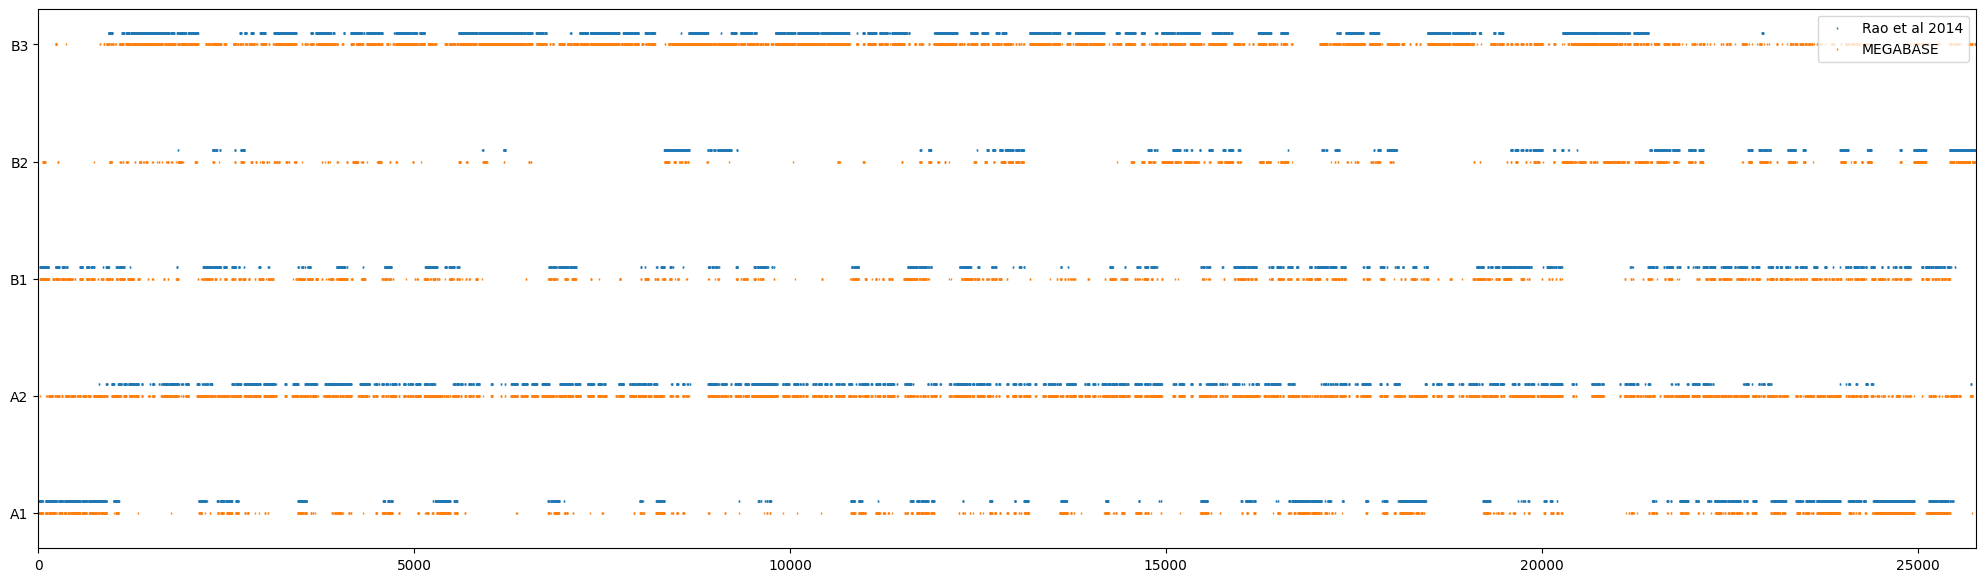

In [130]:
idx=(lt!=6)
plt.figure(figsize=(25,7))
plt.plot(lt[idx],'s',markersize=1,label='Rao et al 2014',marker='|')
plt.plot(l[idx]-0.1,'s',markersize=1, label='MEGABASE',marker='|')
plt.yticks(np.array([0,1,2,3,4])-0.1,['A1','A2','B1','B2','B3'])
plt.ylim([-0.4,4.2])
plt.xlim([0,len(lt[idx])])
plt.legend(loc='upper right')